In [ ]:
path = 'Potholes/annotated-images/'
splits = 'Potholes/splits.json'
data = 'proposals.pkl'
# path = r'C:/Users/Frederik/Programming/IntroductionToComputerVison/Project_3/Potholes/annotated-images/'
# splits = r'C:/Users/Frederik/Programming/IntroductionToComputerVison/Project_3/Potholes/splits.json'



In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.ops import RoIAlign
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import functional as Fs
from torchvision import transforms as v2
import torchvision.ops as ops
import torch
import json
from xml.etree import ElementTree as ET
from torch.utils.data import DataLoader
from torchvision.io import decode_image
from torchvision.utils import draw_bounding_boxes
from sklearn.model_selection import train_test_split
from torchvision import tv_tensors
from torchvision.transforms import v2
import pickle


# speed-up using multithreads
cv2.setUseOptimized(True)
cv2.setNumThreads(8)

def selective_search(image_path, num_rects, quality=True):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    image = cv2.imread(image_path)
    ss.setBaseImage(image)

    ss.switchToSelectiveSearchFast()
        
    rects = ss.process()

    return rects[:num_rects]

def show_selective_search(image, rects):
    imOut = image.copy()

    # itereate over all the region proposals
    for _, rect in enumerate(rects):
        # draw rectangle for region proposal
        x, y, w, h = rect
        color = list(np.random.random(size=3) * 256)
        cv2.rectangle(imOut, (x, y), (x+w, y+h), color, 2, cv2.LINE_AA)

    plt.imshow(imOut[...,::-1])
    plt.axis('off')

def read_xml(path: str) -> list:  
    tree = ET.parse(path)
    root = tree.getroot()

    obj_list = []

    for obj in root.iter('object'):

        ymin = int(obj.find("bndbox/ymin").text)
        xmin = int(obj.find("bndbox/xmin").text)
        ymax = int(obj.find("bndbox/ymax").text)
        xmax = int(obj.find("bndbox/xmax").text)

        bbox = (xmin, ymin, xmax, ymax)
        obj_list.append(bbox)
    
    return obj_list

def collate_fn(batch):
    return tuple(zip(*batch))

def visualize_boxes(images, annotations):
    all_images = []
    all_overlay = []

    for image, annotation in zip(images, annotations):
        
        overlay = draw_bounding_boxes(image, annotation, width=2)
        all_images.append(image)
        all_overlay.append(overlay)
    
    fig, axes = plt.subplots(len(all_images), 2, figsize=(10, len(all_images) * 5))
    
    for idx, image in enumerate(all_images):
        axes[idx, 0].imshow(image.permute(1,2,0))
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(all_overlay[idx].permute(1,2,0))
        axes[idx, 1].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    plt.show()
        
# class RCNN(nn.Module):
#     def __init__(self):
#         super(RCNN, self).__init__()

#         self.convolutional1 = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)  # 224x224 -> 112x112
#         )
        
#         self.convolutional2 = nn.Sequential(
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)  # 112x112 -> 56x56
#         )
        
#         self.convolutional3 = nn.Sequential(
#             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)  # 56x56 -> 28x28
#         )
        
#         self.convolutional4 = nn.Sequential(
#             nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)  # 28x28 -> 14x14
#         )

#         self.convolutional5 = nn.Sequential(
#             nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(1024),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)  # 14x14 -> 7x7
#         )

#         self.convolutional6 = nn.Sequential(
#             nn.Conv2d(1024, 2048, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(2048),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)  # 7x7 -> 3x3
#         )

#         # Fully connected layer
#         self.fully_connected = nn.Sequential(
#             nn.Linear(2048 * 3 * 3, 2048), 
#             nn.BatchNorm1d(2048),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(2048, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(512, 2)
#         )

#     def forward(self, x):
#         x = self.convolutional1(x)
#         x = self.convolutional2(x)
#         x = self.convolutional3(x)
#         x = self.convolutional4(x)
#         x = self.convolutional5(x)
#         x = self.convolutional6(x)

#         x = x.view(x.size(0), -1)

#         x = self.fully_connected(x)
#         x = x.squeeze(1) 

#         return x


class RCNN(nn.Module):
    def __init__(self):
        super(RCNN, self).__init__()

        self.convolutional1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 224x224 -> 112x112
        )
        
        self.convolutional2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 112x112 -> 56x56
        )
        
        self.convolutional3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 56x56 -> 28x28
        )
        
        self.convolutional4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 28x28 -> 14x14
        )

        # Fully connected layer
        self.fully_connected = nn.Sequential(
            nn.Linear(512 * 14 * 14, 2048),  # Adjusted to match the output size after 4 conv layers
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.convolutional1(x)
        x = self.convolutional2(x)
        x = self.convolutional3(x)
        x = self.convolutional4(x)

        x = x.view(x.size(0), -1)

        x = self.fully_connected(x)
        x = x.squeeze(1)

        return x



In [50]:

class Pothole_Dataset(torch.utils.data.Dataset):
    def __init__(self, data, feature_size=256, pos_thresh=.7, neg_thresh=.3, val=False, device="cpu"):
        self.data = data
        self.size = feature_size
        self.pos_thresh = pos_thresh
        self.neg_thresh = neg_thresh
        self.val = val
        self.device = device

        self.transforms = v2.Compose([
                            v2.RandomHorizontalFlip(),
                            v2.RandomVerticalFlip()
                          ])

    def __len__(self):
        return len(self.data)
    

    def __getitem__(self, idx):
        datum = self.data[idx]
        image = decode_image(datum[0]).to(self.device)
        ground_truths = datum[1].to(self.device)
        regions = datum[2].to(self.device)

        ious = ops.box_iou(regions, ground_truths)

        # Select proposals with IoU >= pos_thresh as positive samples
        pos_indices = (ious.max(dim=1)[0] >= self.pos_thresh).nonzero(as_tuple=True)[0]
        pos_samples = regions[pos_indices]

        # Select proposals with IoU < neg_thresh as background samples
        bg_indices = (ious.max(dim=1)[0] < self.neg_thresh).nonzero(as_tuple=True)[0]
        num_bg = int(len(pos_samples) * 4)  # Make background samples 80% of total proposals
        bg_samples = regions[bg_indices[:num_bg]]
        
        # Concatenate positive and background samples 
        selected_regions = torch.cat([pos_samples, bg_samples], dim=0) 
        region_labels = torch.cat([torch.ones(len(pos_samples), device=self.device), torch.zeros(num_bg, device=self.device)])

        # Collect and stack image elements
        batched_image = image.unsqueeze(0).float()
        # 2. Format boxes for ROI Align
        # ROI Align expects boxes in format (batch_idx, x1, y1, x2, y2)
        N = len(selected_regions)
        # Add batch index (0) as first column
        batched_regions = torch.zeros(N, 5, device=self.device)
        batched_regions[:, 1:] = selected_regions  # Copy x1, y1, x2, y2        

        # 3. Extract ROIs using ROI Align
        rois = ops.roi_align(
            input=batched_image,        # (1, C, H, W)
            boxes=batched_regions,        # (N, 5)
            output_size=(self.size, self.size),
            spatial_scale=1.0,          # No scaling if boxes are in absolute coords
            aligned=True                # Better alignment with original image
        )
        
        if not self.val:
            rois = self.transforms(rois)
        
        return image, ground_truths, regions, selected_regions, region_labels, rois

In [ ]:
feature_size = 224
batch_size = 32
num_workers = 1
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [60]:
pkl_file = 'proposals.pkl'
with open(pkl_file, 'rb') as file:
    data = pickle.load(file)

train_len = 532
train_data = data[:train_len]
val_data, test_data = train_test_split(data[train_len:], train_size=.5)

trainset = Pothole_Dataset(train_data, feature_size=feature_size, device=device)
valset = Pothole_Dataset(val_data, feature_size=feature_size, device=device, val=True)
testset = Pothole_Dataset(test_data, feature_size=feature_size, device=device, val=True)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_fn)
val_loader= DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)

In [76]:
images, ground_truths, regions, selected_regions, region_labels, rois = next(iter(train_loader))

In [77]:
rois[0].shape

torch.Size([40, 3, 224, 224])

In [20]:
def unpack_and_process_batch(batch):
    """
    A way to unpack the tuples we get from the dataloader, and handles cases where batches are empty.  
    """

    images, ground_truths, regions, selected_regions, region_labels, rois = batch

    all_rois = []
    all_labels = []

    for i in range(len(rois)):
        current_rois = rois[i]  
        current_labels = region_labels[i] 

        # Check if the current image has valid ROIs and labels; skip if missing
        if current_rois.size(0) == 0 or current_labels.size(0) == 0:
            #print(f"Warning: Skipping image {i} in batch due to no ROIs or labels.")
            continue
            
        all_rois.append(current_rois)
        all_labels.append(current_labels)

    if all_rois:
        processed_rois = torch.cat(all_rois, dim=0)
        processed_labels = torch.cat(all_labels, dim=0).long()
        return processed_rois, processed_labels
    else:
        #print("Warning: No valid ROIs or labels in the entire batch.")
        return torch.empty(0), torch.empty(0)

# Pre-trained CNN

In [21]:
import torch
import torch.nn as nn
import torchvision.models as models

import os
import csv
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


num_classes = 2  # 1 class + 1 background class
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet50(pretrained=True)
model = model.to(device)
model.fc = nn.Linear(model.fc.in_features, num_classes) 

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final fully connected layer
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.AdamW(model.fc.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()



c:\Users\Frederik\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Frederik\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def finetune_CNN(model, dataloader, optimizer, criterion, num_epochs):
    mini_batch = 64
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.train()
    
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()  # Set model to training mode
        running_loss = 0.0
        train_correct = 0
        total_samples = 0

        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
            rois, labels = unpack_and_process_batch(batch)

            # batches can come in very high amounts, so to ensure even batch we use split
            # does come at the cost of gradients from minibatch of the rois. 
            rois = torch.split(rois, mini_batch)
            labels = torch.split(labels, mini_batch)

            for batch_rois, batch_labels in zip(rois, labels):
                batch_rois = batch_rois.to(device)
                batch_labels = batch_labels.to(device)

                optimizer.zero_grad()
                output = model(batch_rois)
            
                loss = criterion(output, batch_labels) 
                predicted = output.argmax(dim=1)  

                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                train_correct += (predicted == batch_labels).sum().item()
                total_samples += batch_labels.size(0)

        epoch_loss = running_loss / len(dataloader)
        accuracy = 100 * train_correct / total_samples
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%')


In [39]:
finetune_CNN(model, train_loader, optimizer, criterion, num_epochs)

  0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1/10:   0%|          | 0/89 [00:00<?, ?batch/s]

Epoch 1/10, Train Loss: 1.8399, Train Accuracy: 83.84%


Epoch 2/10:   0%|          | 0/89 [00:00<?, ?batch/s]

Epoch 2/10, Train Loss: 1.6090, Train Accuracy: 86.85%


Epoch 3/10:   0%|          | 0/89 [00:00<?, ?batch/s]

Epoch 3/10, Train Loss: 1.6170, Train Accuracy: 86.61%


Epoch 4/10:   0%|          | 0/89 [00:00<?, ?batch/s]

Epoch 4/10, Train Loss: 1.5677, Train Accuracy: 87.01%


Epoch 5/10:   0%|          | 0/89 [00:00<?, ?batch/s]

Epoch 5/10, Train Loss: 1.4470, Train Accuracy: 88.15%


Epoch 6/10:   0%|          | 0/89 [00:00<?, ?batch/s]

Epoch 6/10, Train Loss: 1.4141, Train Accuracy: 88.35%


Epoch 7/10:   0%|          | 0/89 [00:00<?, ?batch/s]

Epoch 7/10, Train Loss: 1.5466, Train Accuracy: 87.60%


Epoch 8/10:   0%|          | 0/89 [00:00<?, ?batch/s]

Epoch 8/10, Train Loss: 1.5697, Train Accuracy: 87.41%


Epoch 9/10:   0%|          | 0/89 [00:00<?, ?batch/s]

Epoch 9/10, Train Loss: 1.5063, Train Accuracy: 88.42%


Epoch 10/10:   0%|          | 0/89 [00:00<?, ?batch/s]

Epoch 10/10, Train Loss: 1.4275, Train Accuracy: 88.61%


# homebrew CNN

In [ ]:
import os
import csv
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Training loop from Hot-dog not hotdog so its a bit different from pre-trained training loop. 
def startTrain(model, criterion, optimizer, num_epochs, save_model=True, model_name="model"):
    mini_batch = 64
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    log_file = f"{model_name}_training_log.csv"
    
    with open(log_file, mode='w+', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["epoch", "train_loss", "test_loss", "train_acc", "test_acc"]) 

    out_dict = {'train_acc': [],
                'test_acc': [],
                'train_loss': [],
                'test_loss': []}

    model.to(device)
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()  # set train mode
        train_correct = 0
        train_total = 0
        train_loss = []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
            rois, labels = unpack_and_process_batch(batch)
            
            # ensures batch_size never causes vram problems
            rois = torch.split(rois, mini_batch)
            labels = torch.split(labels, mini_batch)
            
            for batch_rois, batch_labels in zip(rois, labels):
                batch_rois = batch_rois.to(device)
                batch_labels = batch_labels.to(device)

                # Skip the batch if the batch size is 1 as it conflicts with BatchNorm
                if batch_rois.size(0) == 1:
                    continue

                optimizer.zero_grad()
                output = model(batch_rois)

                predicted = torch.softmax(output, dim=1) 
                predicted_class = torch.argmax(predicted, dim=1)

                loss = criterion(output, batch_labels)

                loss.backward()
                optimizer.step()

                # Compare predicted class with label_batch
                train_correct += (batch_labels == predicted_class).sum().item()
                train_total += batch_labels.size(0)
                train_loss.append(loss.item())


        train_acc = train_correct / train_total

        out_dict['train_acc'].append(train_acc)
        out_dict['train_loss'].append(np.mean(train_loss))

        print(f"Epoch {epoch+1}")
        print(f"Loss train: {np.mean(train_loss):.3f}\t",
              f"Accuracy train: {train_acc * 100:.1f}%\t")

        with open(log_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([epoch + 1, np.mean(train_loss), train_acc])

    if save_model:
        model_save_path = f"{model_name}.pt"
        torch.save(model.state_dict(), model_save_path)
        print(f"Succesfully saved as: {model_save_path}")
    
    return out_dict


# Plotting function
def plot_func(out_dict, acc_title="Train Accuracy over Epochs", loss_title="Train Loss over Epochs"):
    sns.set(style="whitegrid")
    
    # Prepare the data for plotting
    epochs = range(1, len(out_dict['train_acc']) + 1)
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot Accuracy with Seaborn
    sns.lineplot(x=epochs, y=out_dict['train_acc'], ax=axes[0], marker='o', label='Train Accuracy')
    #sns.lineplot(x=epochs, y=out_dict['test_acc'], ax=axes[0], marker='o', label='Test Accuracy')
    axes[0].set_title(acc_title)
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_ylim(0.5, 1)  
    axes[0].set_xticks(epochs)
    axes[0].legend()

    # Plot Loss with Seaborn
    sns.lineplot(x=epochs, y=out_dict['train_loss'], ax=axes[1], marker='o', label='Train Loss')
    #sns.lineplot(x=epochs, y=out_dict['test_loss'], ax=axes[1], marker='o', label='Test Loss')
    axes[1].set_title(loss_title)
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Cross-Entropy Loss')
    axes[1].set_xticks(epochs)
    axes[1].legend()
    
    # Layout adjustment
    plt.tight_layout()
    plt.show()


  0%|          | 0/2 [00:00<?, ?epoch/s]

Epoch 1/2:   0%|          | 0/89 [00:00<?, ?batch/s]

Epoch 1
Loss train: 0.399	 Accuracy train: 81.5%	


Epoch 2/2:   0%|          | 0/89 [00:00<?, ?batch/s]

Epoch 2
Loss train: 0.339	 Accuracy train: 84.6%	
Succesfully saved as: CNN_object_detection.pt


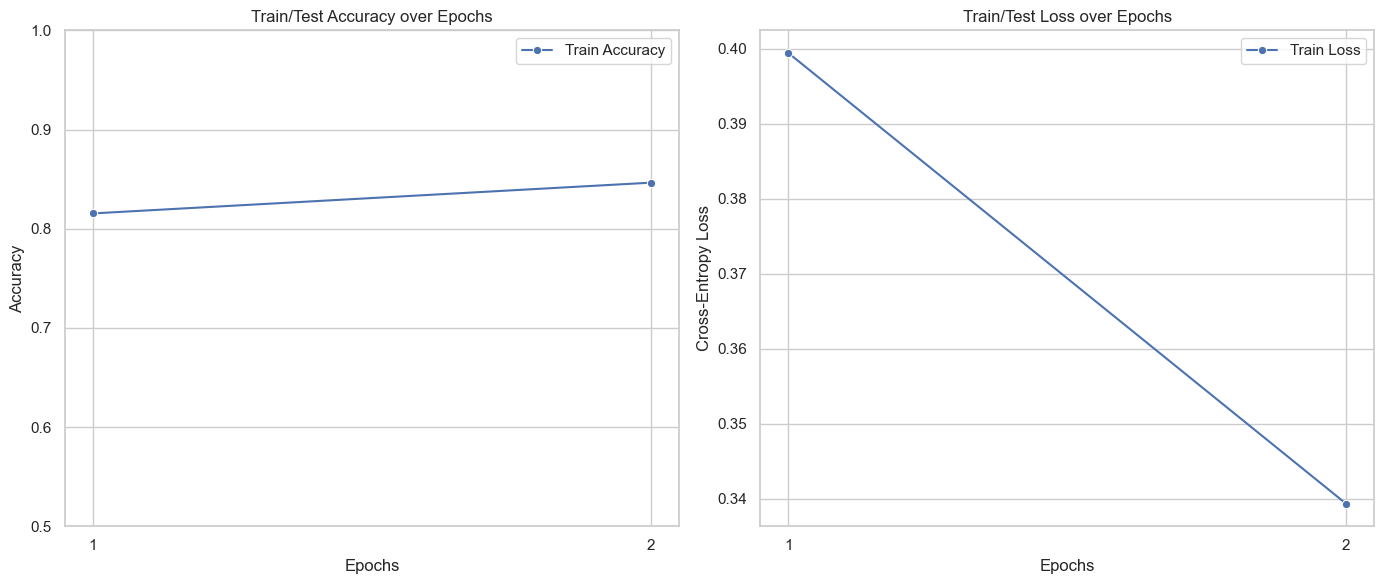

In [47]:
# Using model above
model1 = RCNN()

# Redundant
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model1.parameters(), lr=0.001, weight_decay=0.001)
num_epochs = 2

out_dict = startTrain(model_name = "CNN_object_detection", model=model1, criterion=criterion, optimizer=optimizer, num_epochs = num_epochs, save_model=True)

plot_func(out_dict)



# NOTE: the above only shows train accuracy and loss. 